<a href="https://colab.research.google.com/github/sekihiro/Colabo/blob/master/TextClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PyTorchを使ってLSTMで文章分類
- 対象：livedoorニュースのタイトル文
- https://qiita.com/m__k/items/841950a57a0d7ff05506
- https://qiita.com/m__k/items/db1a81bb06607d5b0ec5

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### livedoor ニュースコーパス 取得

In [0]:
%cd "/content/drive/My Drive/git/LDCC/data"
%ls -al
!wget https://www.rondhuit.com/download/ldcc-20140209.tar.gz
!tar zxvf ldcc-20140209.tar.gz
%ls -al

/content/drive/My Drive/git/LDCC/data
total 0
--2020-01-05 02:36:31--  https://www.rondhuit.com/download/ldcc-20140209.tar.gz
Resolving www.rondhuit.com (www.rondhuit.com)... 59.106.19.174
Connecting to www.rondhuit.com (www.rondhuit.com)|59.106.19.174|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8855190 (8.4M) [application/x-gzip]
Saving to: ‘ldcc-20140209.tar.gz’

ldcc-20140209.tar.g 100%[===================>]   8.44M  1.77MB/s    in 6.4s    

2020-01-05 02:36:38 (1.32 MB/s) - ‘ldcc-20140209.tar.gz’ saved [8855190/8855190]

text/
text/CHANGES.txt
text/dokujo-tsushin/
text/it-life-hack/
text/kaden-channel/
text/livedoor-homme/
text/movie-enter/
text/peachy/
text/README.txt
text/smax/
text/sports-watch/
text/topic-news/
text/topic-news/LICENSE.txt
text/topic-news/topic-news-5903225.txt
text/topic-news/topic-news-5903373.txt
text/topic-news/topic-news-5907376.txt
text/topic-news/topic-news-5908396.txt
text/topic-news/topic-news-5910461.txt
text/topic-news/to

In [2]:
%cd "/content/drive/My Drive/git/LDCC/data/text/"
%ls -al

/content/drive/My Drive/git/LDCC/data/text
total 36
drwx------ 2 root root 4096 Feb  9  2014 dokujo-tsushin/
drwx------ 2 root root 4096 Feb  9  2014 it-life-hack/
drwx------ 2 root root 4096 Feb  9  2014 kaden-channel/
drwx------ 2 root root 4096 Feb  9  2014 livedoor-homme/
drwx------ 2 root root 4096 Feb  9  2014 movie-enter/
drwx------ 2 root root 4096 Feb  9  2014 peachy/
drwx------ 2 root root 4096 Feb  9  2014 smax/
drwx------ 2 root root 4096 Feb  9  2014 sports-watch/
drwx------ 2 root root 4096 Feb  9  2014 topic-news/


In [3]:
!nvidia-smi

Tue Feb 11 07:22:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [5]:
!cat /usr/include/cudnn.h | grep CUDNN_MAJOR -A 2

#define CUDNN_MAJOR 7
#define CUDNN_MINOR 6
#define CUDNN_PATCHLEVEL 5
--
#define CUDNN_VERSION (CUDNN_MAJOR * 1000 + CUDNN_MINOR * 100 + CUDNN_PATCHLEVEL)

#include "driver_types.h"


### **MeCab** を Google-Colaboratory で使えるようにする

In [6]:
!apt install aptitude
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  aptitude-common libcgi-fast-perl libcgi-pm-perl libclass-accessor-perl
  libcwidget3v5 libencode-locale-perl libfcgi-perl libhtml-parser-perl
  libhtml-tagset-perl libhttp-date-perl libhttp-message-perl libio-html-perl
  libio-string-perl liblwp-mediatypes-perl libparse-debianchangelog-perl
  libsigc++-2.0-0v5 libsub-name-perl libtimedate-perl liburi-perl libxapian30
Suggested packages:
  aptitude-doc-en | aptitude-doc apt-xapian-index debtags tasksel
  libcwidget-dev libdata-dump-perl libhtml-template-perl libxml-simple-perl
  libwww-perl xapian-tools
The following NEW packages will be installed:
  aptitude aptitude-common libcgi-fast-perl libcgi-pm-perl
  libclass-accessor-perl libcwidget3v5 libencode-l

In [0]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import easydict
import time
import math
import random
from tqdm import tqdm
import pprint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import cloudpickle
import os
from glob import glob
import pandas as pd
import linecache
import MeCab
import re
import collections
%matplotlib inline

In [8]:
# 再現性確保
def seed_everything(seed=1234):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    return seed

# 再現性確保
ret = seed_everything(1234)
print('seed : {}'.format(ret))

# select device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device : {}'.format(device))

seed : 1234
device : cuda


### データ準備

In [9]:
# テキスト内容を確認１
!head "/content/drive/My Drive/git/LDCC/data/text/dokujo-tsushin/dokujo-tsushin-4778030.txt"

http://news.livedoor.com/article/detail/4778030/
2010-05-22T14:30:00+0900
友人代表のスピーチ、独女はどうこなしている？
　もうすぐジューン・ブライドと呼ばれる６月。独女の中には自分の式はまだなのに呼ばれてばかり……という「お祝い貧乏」状態の人も多いのではないだろうか？　さらに出席回数を重ねていくと、こんなお願いごとをされることも少なくない。

　「お願いがあるんだけど……友人代表のスピーチ、やってくれないかな？」

　さてそんなとき、独女はどう対応したらいいか？

　最近だとインターネット等で検索すれば友人代表スピーチ用の例文サイトがたくさん出てくるので、それらを参考にすれば、無難なものは誰でも作成できる。しかし由利さん（33歳）はネットを参考にして作成したものの「これで本当にいいのか不安でした。一人暮らしなので聞かせて感想をいってくれる人もいないし、かといって他の友人にわざわざ聞かせるのもどうかと思うし……」ということで活用したのが、なんとインターネットの悩み相談サイトに。そこに作成したスピーチ文を掲載し「これで大丈夫か添削してください」とメッセージを送ったというのである。


In [10]:
# テキスト内容を確認２
!head "/content/drive/My Drive/git/LDCC/data/text/it-life-hack/it-life-hack-6292880.txt"

http://news.livedoor.com/article/detail/6292880/
2012-02-19T13:00:00+0900
旧式Macで禁断のパワーアップ！最新PCやソフトを一挙にチェック【ITフラッシュバック】
テレビやTwitterと連携できるパソコンや、プロセッサや切り替わるパソコンなど、面白いパソコンが次から次へと登場した。旧式Macの禁断ともいえるパワーアップ方法から、NECの最新PC、話題のThinkPad X1 Hybrid、新セキュリティソフトまで一挙に紹介しよう。

■インテル SSD 520をMacに装着！旧式Macはどれほど高速化するのか (上)
インテルが最新SSD「520シリーズ」を発売した。現行SSDの中でもトップクラスの性能を誇る同製品を、旧型Macの高速化を図るというポイントでレビューしてみた。少し風変わりなレビューとなるが、どの程度の効果があるか、期待大である。


■http://itlifehack.jp/archives/6716997.html


In [0]:
BASE_PATH = "/content/drive/My Drive/git/LDCC/"
DATA_PATH = BASE_PATH + 'data/text/'
PICKLE_PATH = BASE_PATH + 'data/ldcc.pkl'

In [12]:
# LDCCテキストファイルからタイトル行をDateFrameに格納し、pickle形式で保存

# カテゴリを配列で取得
categories = [name for name in os.listdir(DATA_PATH) if os.path.isdir(DATA_PATH + name)]
print(categories)
time.sleep(1)
# ['movie-enter', 'it-life-hack', 'kaden-channel', 'topic-news', 'livedoor-homme', 'peachy', 'sports-watch', 'dokujo-tsushin', 'smax']

if os.path.isfile(PICKLE_PATH):
    print(PICKLE_PATH + ' is exists ... ')
else:
    # データフレーム作成
    datasets = pd.DataFrame(columns=["title", "category"])
    for cat in categories:
        path = DATA_PATH + cat + "/*.txt"
        files = glob(path)
        print('\n' + cat + '\n')
        time.sleep(1)
        for text_name in tqdm(files):
            # 各テキストファイルの3行目にタイトル文字列の記載がある
            title = linecache.getline(text_name, 3)
            s = pd.Series([title, cat], index=datasets.columns)
            datasets = datasets.append(s, ignore_index=True)

    # データフレームシャッフル
    print('\n len : {}'.format(len(datasets)))
    datasets = datasets.sample(frac=1).reset_index(drop=True)
    datasets.head()

    # PICKLE形式で保存
    datasets.to_pickle(PICKLE_PATH)
    print(PICKLE_PATH + ' is saved ...')

['dokujo-tsushin', 'livedoor-homme', 'kaden-channel', 'smax', 'topic-news', 'peachy', 'movie-enter', 'it-life-hack', 'sports-watch']
/content/drive/My Drive/git/LDCC/data/ldcc.pkl is exists ... 


In [13]:
# PICKLE形式のDataFrameを読み込む
datasets = pd.read_pickle(PICKLE_PATH)
datasets.head()

,title,category
0,貞子がついに上戸彩と並んだ！ 野球カード化が決定\n,movie-enter
1,人間のボクシングは死に絶え、時代は“最強”ロボット格闘技へ\n,movie-enter
2,乗り換えたいけど、スマホって本当に便利？ ケータイ大好きOLの女子座談会へ潜入\n,livedoor-homme
3,くさったよめがあらわれた！vol.05「自分を変えたい…それは楽しめることをみつけること!!...,dokujo-tsushin
4,ウリナリ的な挑戦企画が人気か？ 日テレ「ヒルナンデス！」が視聴率初の昼トップに【話題】\n,kaden-channel


### データ前処理

PyTorchでLSTMをする際、食わせるインプットデータは３次元のテンソルある必要があります。<br>具体的には、文章の長さ × バッチサイズ × ベクトル次元数 となっています。<br>
今回のインプットデータは文章（livedoorニュースのタイトル文）であり、この文章を3次元テンソルに変換する必要があります。<br>
バッチサイズは一旦無視して、ひとまず文章を以下のように２次元のマトリクスに変換することを考えます。


---


人工知能は人間の仕事を奪った

(形態素解析) → ['人工','知能','は','人間','の','仕事','を','奪っ','た']

(各単語をベクトルで置換)→<br>
[<br>
[0.2 0.5 -0.9 1.3 ...], # 「人口」の単語ベクトル<br>
[1.3 0.1 2.9 -1.3 ...], # 「知能」の単語ベクトル<br>
...<br>
[0.9 -0.3 -0.1 3.0 ...] # 「た」の単語ベクトル<br>
]<br>

単語のベクトルは例えばWord2Vecで学習済みのものがあればそれを使う方が精度が良いらしいですが、<br>一旦はPyTorchの torch.nn.Embedding を使いましょう。<br>
こいつの詳細はPyTorchのチュートリアルに任せますが、要はランダムな単語ベクトル群を生成してくれるやつです。<br>実際に使ってみると分かりやすいです。

In [14]:
# torch.nn.Embedding の使い方

# 以下の宣言で行が単語ベクトル、列が単語のインデックスのマトリクスを生成してる感じ
embeds = nn.Embedding(10, 6) # (Embedding(単語の合計数, ベクトル次元数))

# ３行目の要素を取り出したいならば
w1 = torch.tensor([2])
print(embeds(w1))
# tensor([[-1.5947, -0.8387,  0.7669, -0.9644, -0.7902,  2.7167]],
#        grad_fn=<EmbeddingBackward>)

# 3行目、5行目、１０行目の要素を取り出したいならば、
w2 = torch.tensor([2,4,9])
print(embeds(w2))
# tensor([[-1.5947, -0.8387,  0.7669, -0.9644, -0.7902,  2.7167],
#        [ 0.0405,  1.4236,  0.1947,  0.2609,  0.2047, -1.4964],
#        [ 1.7325, -0.2543, -0.5139, -0.9527, -0.1344,  0.0984]],
#       grad_fn=<EmbeddingBackward>)

tensor([[-0.3424, -1.4020,  0.3206, -1.0219,  0.7988, -0.0923]],
       grad_fn=<EmbeddingBackward>)
tensor([[-0.3424, -1.4020,  0.3206, -1.0219,  0.7988, -0.0923],
        [-0.1706, -1.4594,  0.2207,  0.2463, -1.3248,  0.6970],
        [ 1.0534,  0.3692,  0.0628, -0.3297, -1.7970,  0.8728]],
       grad_fn=<EmbeddingBackward>)


In [15]:
# 文章を単語IDの系列データとして変換する方法の確認

tagger = MeCab.Tagger("-Owakati")

def make_wakati(sentence):
    # MeCabで分かち書き
    sentence = tagger.parse(sentence)
    # 半角全角英数字除去
    sentence = re.sub(r'[0-9０-９a-zA-Zａ-ｚＡ-Ｚ]+', " ", sentence)
    # 記号もろもろ除去
    sentence = re.sub(r'[\．_－―─！＠＃＄％＾＆\-‐|\\＊\“（）＿■×+α※÷⇒—●★☆〇◎◆▼◇△□(：〜～＋=)／*&^%$#@!~`){}［］…\[\]\"\'\”\’:;<>?＜＞〔〕〈〉？、。・,\./『』【】「」→←○《》≪≫\n\u3000]+', "", sentence)
    # スペースで区切って形態素の配列へ
    wakati = sentence.split(" ")
    # 空の要素は削除
    wakati = list(filter(("").__ne__, wakati))
    return wakati

# テスト
test = "今日はそういう日だったのか！Googleロゴが変わっている理由"
print('make_wakati TEST:')
print(make_wakati(test))

# 単語ID辞書を作成する
word2index = {}
for title in datasets["title"]:
    wakati = make_wakati(title)
    for word in wakati:
        if word in word2index: continue
        word2index[word] = len(word2index)
print("\nvocab size : {}\n".format(len(word2index)))
# (例) vocab size :  13229

# どんな辞書になっているか先頭から20件出力
i = 0
print('key\tval\n----------')
for mykey, myvalue in word2index.items():
    i = i + 1
    if i<= 10 or (i >=470 and i<=480) or (i >= 9900 and i<= 9910):
        print("{}\t{}".format(mykey, myvalue))

# 文章を単語IDの系列データに変換
# PyTorchのLSTMのインプットになるデータなので、もちろんtensor型で
def sentence2index(sentence):
    wakati = make_wakati(sentence)
    return torch.tensor([word2index[w] for w in wakati], dtype=torch.long)

# テスト
# 実際にLDCCに存在する「title」にすること
#test = "これで今日からExcelの達人！ビジネスに必須のExcel基本ワザ【知っ得！虎の巻】"
print('\nsentence2index TEST:')
print(test + '\n↓')
ret = sentence2index(test)
print(type(ret))
print(ret)
# (例) tensor([11320,     3,   449,  5483,    26,  3096,  1493,  1368,     3, 11371, 7835,   174,  8280])

make_wakati TEST:
['今日', 'は', 'そういう', '日', 'だっ', 'た', 'の', 'か', 'ロゴ', 'が', '変わっ', 'て', 'いる', '理由']

vocab size : 9965

key	val
----------
貞子	0
が	1
ついに	2
上戸	3
彩	4
と	5
並ん	6
だ	7
野球	8
カード	9
森	469
監督	470
作品	471
今日	472
秋刀魚	473
ビデオ	474
次世代	475
ジェットコースターショッカーミステリー	476
スクリーム	477
ブルー	478
レイ	479
エチカ	9899
ぐっすり	9900
眠れる	9901
ヒーローズ	9902
発狂	9903
悲し	9904
げ	9905
コンパス	9906
客観	9907
進め	9908
ダイヤ	9909

sentence2index TEST:
今日はそういう日だったのか！Googleロゴが変わっている理由
↓
<class 'torch.Tensor'>
tensor([ 472,   15, 1783,  285, 1207,   37,   13,   56, 1012,    1,  689,  113,
         249,  802])


In [16]:
# 全単語数を取得
# word2index：
# 　全てデータ(LDCCのニュースタイトル)をMeCabで形態素に分かち書きし、
# 　形態素毎にINDEXを付与したもの
VOCAB_SIZE = len(word2index)
print('VOCAB_SIZE : {}\n'.format(VOCAB_SIZE))

# 単語のベクトル数を定義
EMBEDDING_DIM = 10

# 単語IDの系列データに変換
# test変数の内容を形態素に分けて、それぞれの形態素のINDEX(word2indexを使う)を得る
# 実際にLDCCに存在する「title」にすること
test = "今日はそういう日だったのか！Googleロゴが変わっている理由"
inputs = sentence2index(test)
print(test + '\n↓')
print('inputs : {}\n'.format(inputs))
test2 = "これで今日からExcelの達人！ビジネスに必須のExcel基本ワザ【知っ得！虎の巻】"
inputs2 = sentence2index(test2)
print(test2 + '\n↓')
print('inputs : {}\n'.format(inputs2))

# 各単語のベクトルをまとめて取得
# 各形態素毎に10次元のベクトルを得る
# ２次元のマトリクスとする
embeds = nn.Embedding(VOCAB_SIZE, EMBEDDING_DIM) # Embedding(単語の合計数, ベクトル次元数)
sentence_matrix = embeds(inputs)
print(test + '\n↓')
print(sentence_matrix.size())
print(sentence_matrix)

VOCAB_SIZE : 9965

今日はそういう日だったのか！Googleロゴが変わっている理由
↓
inputs : tensor([ 472,   15, 1783,  285, 1207,   37,   13,   56, 1012,    1,  689,  113,
         249,  802])

これで今日からExcelの達人！ビジネスに必須のExcel基本ワザ【知っ得！虎の巻】
↓
inputs : tensor([ 134,  105,  472,  176,   13, 7126,  124,   64, 2782,   13,  881,  123,
         129,  130,  131])

今日はそういう日だったのか！Googleロゴが変わっている理由
↓
torch.Size([14, 10])
tensor([[ 1.8636e+00, -1.0910e+00, -1.1969e+00,  3.3377e-01, -4.4827e-01,
         -3.6077e-01,  1.4155e+00, -5.0984e-01, -9.5917e-01,  7.4717e-01],
        [-6.3918e-02,  3.0292e+00,  2.5377e-01,  8.2522e-02, -1.1314e+00,
          3.9972e-01,  3.5863e-01, -2.3594e+00, -1.3954e+00,  8.6747e-01],
        [ 6.9869e-02, -1.0371e+00,  3.8296e-01, -2.0071e+00,  1.9310e-01,
         -4.5787e-02, -7.6356e-01,  1.1115e+00,  2.2504e-01, -1.8004e+00],
        [-1.4746e-01, -6.4389e-01, -7.5567e-01,  1.1182e+00, -2.1282e+00,
         -1.7754e+00,  3.3990e-01,  1.6427e+00, -1.8038e+00,  3.7238e-01],
        [ 6.8435e-01, -

PyTorchでLSTMをする際、食わせるインプットデータは３次元のテンソルある必要があります。<br>
具体的には、文章の長さ × バッチサイズ × ベクトル次元数 となっています。

In [17]:
# ２次元 → ３次元
# 今回は（とりあえず）バッチサイズは１とする
# viewの引数の-1は、「残り全て」を示す
# 第１引数：タイトルを分かち書きした形態素数
# 第２引数：バッチサイズ
# 第３引数：残り
# バッチサイズ「1」の場合は、
# 形態素数×ベクトル数と形態素数×バッチサイズ(1)×ベクトル数で
# 形態素数とベクトル数は、２次元でも３次元でも変化しない
sentence_matrix.view(len(sentence_matrix), 1, -1).size()
#print(sentence_matrix3)
#print(type(sentence_matrix3))

torch.Size([14, 1, 10])

### モデル定義

In [18]:
# torch.nn.LSTM の使い方

EMBEDDING_DIM = 10
HIDDEN_DIM = 128

s1 = "今日はそういう日だったのか！Googleロゴが変わっている理由"
print(make_wakati(s1))

VOCAB_SIZE = len(word2index)
print('VOCAB_SIZE : {}'.format(VOCAB_SIZE))

# 単語IDの系列データに変換
inputs1 = sentence2index(s1)
print('sentence2index : {}\n'.format(inputs1))

# 各形態素毎に10次元のベクトルを得る (2次元)
embeds = nn.Embedding(VOCAB_SIZE, EMBEDDING_DIM) # Embedding(単語の合計数, ベクトル次元数)
emb1 = embeds(inputs1)
print(emb1.size())
print('emb1 : {}\n'.format(emb1))

# 2次元 → 3次元
lstm_inputs1 = emb1.view(len(inputs1), 1, -1)
print(lstm_inputs1.size())
print('lstm_inputs1 : {}\n'.format(lstm_inputs1))

# LSTMコンストラクタ
# 引数(入力ベクトルの次元数, 隠れ状態の次元数)
lstm = nn.LSTM(EMBEDDING_DIM, HIDDEN_DIM)

# LSTM予測
# out1：出力
# out2：[0]最後の隠れ層の状態, [1]最後のメモリセル
out1, out2 = lstm(lstm_inputs1)
print('out1 : {}\n'.format(out1))
print('out2[0] : {}\n'.format(out2[0]))
print('out2[1] : {}\n'.format(out2[1]))

# 今回の例で言えば、文章(many)を１つのカテゴリに分類(one)したいので、 
# many to one のモデルです。なので、LSTMの最後の隠れ層の出力を使うことになるでしょう。
print('----------------------------------------')
print('必要な情報：')
print('out2[0] : {}\n'.format(out2[0]))

['今日', 'は', 'そういう', '日', 'だっ', 'た', 'の', 'か', 'ロゴ', 'が', '変わっ', 'て', 'いる', '理由']
VOCAB_SIZE : 9965
sentence2index : tensor([ 472,   15, 1783,  285, 1207,   37,   13,   56, 1012,    1,  689,  113,
         249,  802])

torch.Size([14, 10])
emb1 : tensor([[-0.7391, -0.2699,  0.5971, -0.1804, -1.0321, -0.2202,  1.0034, -0.8345,
          1.1180, -0.1778],
        [-1.3238,  1.4525, -0.6788,  0.5478,  0.2297, -0.6999, -0.4498,  0.0369,
         -0.9946, -0.6238],
        [-1.8401,  1.1266,  1.6470,  0.3206,  1.5518,  0.7403,  0.7466,  0.3278,
         -0.3524, -1.9578],
        [-0.3467,  0.7206,  0.2003, -0.9189, -0.8895, -1.4803,  2.0345, -0.5642,
          0.5577,  1.0044],
        [ 0.1208, -0.2749, -1.0806, -0.3476,  0.7676, -1.5509, -0.4261,  1.8126,
          0.5257, -0.3452],
        [ 1.8475, -0.4634,  1.7881, -1.4666,  0.3842,  0.3938, -0.5951,  0.1148,
         -0.3893, -0.8532],
        [-0.2698,  0.7935,  1.0303, -1.4394,  0.3163, -0.7022,  0.8305,  0.7043,
         -1.6797,  

In [0]:
# nn.Moduleを継承して新しいクラスを作る。決まり文句
class LSTMClassifier(nn.Module):
    # モデルで使う各ネットワークをコンストラクタで定義
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        # 親クラスのコンストラクタ。決まり文句
        super(LSTMClassifier, self).__init__()
        # 隠れ層の次元数。これは好きな値に設定しても行列計算の過程で出力には出てこないので。
        self.hidden_dim = hidden_dim
        # インプットの単語をベクトル化するために使う
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        # LSTMの隠れ層。これ１つでOK。超便利。
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        # LSTMの出力を受け取って全結合してsoftmaxに食わせるための１層のネットワーク
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        # softmaxのLog版。dim=0で列、dim=1で行方向を確率変換。
        self.softmax = nn.LogSoftmax(dim=1)

    # 順伝播処理はforward関数に記載
    def forward(self, sentence):
        # 文章内の各単語をベクトル化して出力。2次元のテンソル
        embeds = self.word_embeddings(sentence)
        # 2次元テンソルをLSTMに食わせられる様にviewで３次元テンソルにした上でLSTMへ流す。
        # 上記で説明した様にmany to oneのタスクを解きたいので、第二戻り値だけ使う。
        _, lstm_out = self.lstm(embeds.view(len(sentence), 1, -1))
        # lstm_out[0]は３次元テンソルになってしまっているので2次元に調整して全結合。
        tag_space = self.hidden2tag(lstm_out[0].view(-1, HIDDEN_DIM))
        # softmaxに食わせて、確率として表現
        tag_scores = self.softmax(tag_space)
        return tag_scores

### 正解ラベルの変換

In [20]:
# 分類先のカテゴリにIDを割り振って、そのIDの値を持つtensorを返す関数を用意

category2index = {}
for cat in categories:
    if cat in category2index: continue
    category2index[cat] = len(category2index)
print(category2index)

def category2tensor(cat):
    return torch.tensor([category2index[cat]], dtype=torch.long)

wk_str = 'it-life-hack'
print('\nwk_str : {}'.format(wk_str))
print('category2index : {}'.format(category2index[wk_str]))
print('category2tensor : {}'.format(category2tensor(wk_str)))

{'dokujo-tsushin': 0, 'livedoor-homme': 1, 'kaden-channel': 2, 'smax': 3, 'topic-news': 4, 'peachy': 5, 'movie-enter': 6, 'it-life-hack': 7, 'sports-watch': 8}

wk_str : it-life-hack
category2index : 7
category2tensor : tensor([7])


### 学習

In [21]:
# 単語のベクトル次元数
EMBEDDING_DIM = 10
# 隠れ層の次元数
HIDDEN_DIM = 128
# データ全体の単語数
VOCAB_SIZE = len(word2index)
# 分類先のカテゴリの数
TAG_SIZE = len(categories)
# モデル宣言
model = LSTMClassifier(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TAG_SIZE).to(device)
# 損失関数はNLLLoss()を使う。LogSoftmaxを使う時はこれを使うらしい。
# torch.nn.CrossEntropy = torch.nn.LogSoftmax + torch.nn.NLLLoss
loss_function = nn.NLLLoss()
# 最適化の手法はSGDで。lossの減りに時間かかるけど、一旦はこれを使う。
optimizer = optim.SGD(model.parameters(), lr=0.01)

print('device : {}'.format(device))
pprint.pprint(model)

device : cuda
LSTMClassifier(
  (word_embeddings): Embedding(9965, 10)
  (lstm): LSTM(10, 128)
  (hidden2tag): Linear(in_features=128, out_features=9, bias=True)
  (softmax): LogSoftmax()
)


In [22]:
# 元データを7:3に分ける（7->学習、3->テスト）
traindata, testdata = train_test_split(datasets, train_size=0.7)
print('len(datasets) : {}'.format(len(datasets)))
print('len(traindata) : {}'.format(len(traindata)))
print('len(testdata) : {}'.format(len(testdata)))

len(datasets) : 4536
len(traindata) : 3175
len(testdata) : 1361


In [23]:
print ('training start ...')

# 各エポックの合計loss値を格納する
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

# ループ回してみる。（バッチ化とか使ってないので結構時間かかる...）
num_epochs = 100
for epoch in range(num_epochs):

    # initialize each epoch
    train_loss = 0
    train_acc = 0
    test_loss = 0
    test_acc = 0

    # ネットワークを学習モードに切り替える
    model.train()
    for title, cat in zip(traindata["title"], traindata["category"]):
        # モデルが持ってる勾配の情報をリセット
        # 毎回バックプロパゲーションの初期値をリセット(勾配リセット)
        # model.zero_grad()
        optimizer.zero_grad()
        # 文章を単語IDの系列に変換（modelに食わせられる形に変換）[２次元]
        # LSTMモデル内では、２次元→３次元をしている
        # (例) tensor([ 472, 15, 1783, 285, 1207, 37, 13, 56, 1012, 1, 689, 113])
        inputs = sentence2index(title).to(device)
        # 順方向の伝播の計算(forwardが呼ばれる)
        outputs = model(inputs)
        # 正解カテゴリをテンソル化
        # (例) tensor([7])
        answer = category2tensor(cat).to(device)
        # 損失関数：予測値と正解ラベル値の違いを計算
        loss = loss_function(outputs, answer)
        # 誤差のバックプロパゲーション(逆伝播)で勾配を求める
        loss.backward()
        # バックプロパゲーションで計算した勾配を元に重みを更新
        optimizer.step()
        # lossを集計
        train_loss += loss.item()
        # 9パターンの分類毎に値が取得できるので、最も値が高い分類をmax(1)で取得
        # max(1)の戻り値の[0]は精度(0〜1)、[1]は予測ラベル
        # sum()で、予測と正解ラベルが合っている数をTensor形式でカウント
        # item()で、Tensorをintへ
        acc = (outputs.max(1)[1] == answer).sum()
        train_acc += acc.item()

    # lossとaccの平均を計算
    avg_train_loss = train_loss / len(traindata)
    avg_train_acc = train_acc / len(traindata)

    # ネットワークを推論モードに切り替える
    model.eval()
    # torch.no_gradで必要のない計算を停止 パラメータの保存を止める(test時にメモリが溢れてしまうのを防止)
    with torch.no_grad():
        for title, cat in zip(testdata["title"], testdata["category"]):
            optimizer.zero_grad()
            inputs = sentence2index(title).to(device)
            outputs = model(inputs)
            answer = category2tensor(cat).to(device)
            #loss = loss_function(outputs, answer)
            #loss.backward()
            #optimizer.step()
            #test_loss += loss.item()
            acc = (outputs.max(1)[1] == answer).sum()
            test_acc += acc.item()
        avg_test_loss = test_loss / len(testdata)
        avg_test_acc = test_acc / len(testdata)

    print("Epoch {}/{} \t train_loss : {:.5f} \t train_acc : {:.5f} \t test_loss : {:.5f} \t test_acc : {:.5f}"
                                    .format(epoch+1, num_epochs, avg_train_loss, avg_train_acc, avg_test_loss, avg_test_acc))

    # append list for polt graph after training
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    test_loss_list.append(avg_test_loss)
    test_acc_list.append(avg_test_acc)

print("training end ...")

# save model
with open(BASE_PATH + 'model/ldcc_lstm_model.pkl', 'wb') as f:
    cloudpickle.dump(model, f)
print("saved training model ...")

training start ...
Epoch 1/100 	 train_loss : 1.90967 	 train_acc : 0.26740 	 test_loss : 0.00000 	 test_acc : 0.26672
Epoch 2/100 	 train_loss : 1.74505 	 train_acc : 0.34614 	 test_loss : 0.00000 	 test_acc : 0.35856
Epoch 3/100 	 train_loss : 1.60782 	 train_acc : 0.41921 	 test_loss : 0.00000 	 test_acc : 0.42101
Epoch 4/100 	 train_loss : 1.49098 	 train_acc : 0.48189 	 test_loss : 0.00000 	 test_acc : 0.49155
Epoch 5/100 	 train_loss : 1.39551 	 train_acc : 0.52283 	 test_loss : 0.00000 	 test_acc : 0.53417
Epoch 6/100 	 train_loss : 1.31568 	 train_acc : 0.55087 	 test_loss : 0.00000 	 test_acc : 0.55253
Epoch 7/100 	 train_loss : 1.24410 	 train_acc : 0.57858 	 test_loss : 0.00000 	 test_acc : 0.57678
Epoch 8/100 	 train_loss : 1.17705 	 train_acc : 0.60661 	 test_loss : 0.00000 	 test_acc : 0.58486
Epoch 9/100 	 train_loss : 1.11349 	 train_acc : 0.63118 	 test_loss : 0.00000 	 test_acc : 0.60911
Epoch 10/100 	 train_loss : 1.05342 	 train_acc : 0.65543 	 test_loss : 0.00000 	

#### 学習結果をグラフで可視化

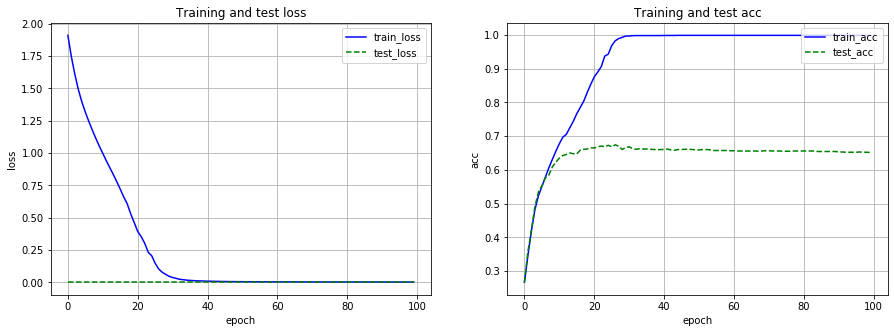

In [24]:
#plt.plot(train_loss_list)
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), test_loss_list, color='green', linestyle='--', label='test_loss')
plt.legend(loc="upper right")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and test loss')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), test_acc_list, color='green', linestyle='--', label='test_acc')
plt.legend(loc="upper right")
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and test acc')
plt.grid()